In [7]:
"""
Marketing MultiAgent System  - Integrated with Real Data Logic
==================================================================
서브그래프 구조 + 실제 PCA 가중치 기반 분석
"""

# GRPC 및 로깅 경고 메시지 무시
import os
os.environ['GRPC_VERBOSITY'] = 'ERROR'
os.environ['GLOG_minloglevel'] = '2'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import json
import pandas as pd
import numpy as np
from typing import List, Dict, Any, Optional, TypedDict, Annotated, Sequence, Literal
from pathlib import Path
import operator
import warnings
import time
from datetime import datetime, date, timedelta
from dotenv import load_dotenv

load_dotenv()
warnings.filterwarnings('ignore')
import logging
logging.getLogger('absl').setLevel(logging.ERROR)

# Langchain & Langgraph
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from pydantic import BaseModel, Field


In [8]:
# ============================================================================
# Configuration
# ============================================================================

MODEL_NAME = "gemini-2.5-flash"
# Use relative path from the current notebook location
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), "data")

In [9]:
# ============================================================================
# 1. Data Models
# ============================================================================

class PCAxisInterpretation(BaseModel):
    """PCA 축 해석"""
    axis: str
    interpretation: str
    top_features: List[Dict] = []

class ClusterProfile(BaseModel):
    """클러스터 프로파일"""
    cluster_id: str
    cluster_name: str
    store_count: int
    pc1_mean: float
    pc2_mean: float
    characteristics: str

class StorePosition(BaseModel):
    """가맹점 포지션"""
    store_id: str
    store_name: str
    industry: str
    pc1_score: float
    pc2_score: float
    cluster_id: str
    cluster_name: str
    competitor_count: int

class WhiteSpace(BaseModel):
    """빈 포지션"""
    pc1_coord: float
    pc2_coord: float
    distance_to_nearest_cluster: float
    opportunity_score: float
    reasoning: str

class StoreRawData(BaseModel):
    """가맹점 원본 데이터"""
    store_id: str
    store_name: str
    industry: str
    commercial_area: str
    monthly_sales: Optional[float] = None
    customer_count: Optional[int] = None
    avg_transaction: Optional[float] = None
    raw_features: Dict = {}

class STPOutput(BaseModel):
    """STP 분석 결과"""
    cluster_profiles: List[ClusterProfile]
    pc_axis_interpretation: Dict[str, PCAxisInterpretation]
    target_cluster_id: str
    target_cluster_name: str
    store_current_position: Optional[StorePosition]
    white_spaces: List[WhiteSpace] = []
    recommended_white_space: Optional[WhiteSpace]
    nearby_competitors: List[Dict] = []
    store_raw_data: Optional[StoreRawData] = None

class StrategyCard(BaseModel):
    """전략 카드"""
    card_id: int
    title: str
    positioning_concept: str
    strategy_4p: Dict[str, str]
    expected_outcome: str
    priority: str
    data_evidence: List[str]

# ============================================================================
# 2. State Definitions
# ============================================================================

class MarketAnalysisState(TypedDict):
    """Market Analysis Team State"""
    messages: Annotated[Sequence[BaseMessage], operator.add]
    target_store_id: str
    target_store_name: str
    current_agent: str
    stp_output: Optional[STPOutput]
    store_raw_data: Optional[StoreRawData]
    next: str

class StrategyPlanningState(TypedDict):
    """Strategy Planning Team State"""
    messages: Annotated[Sequence[BaseMessage], operator.add]
    task_type: str
    stp_output: STPOutput
    store_raw_data: Optional[StoreRawData]
    situation: Optional[Dict]
    target_market_id: Optional[str]
    period_start: Optional[str]
    period_end: Optional[str]
    current_agent: str
    stp_validation_result: Optional[Dict]
    data_4p_mapped: Optional[Dict]  # 🔥 4P 매핑 데이터
    llm_raw_strategy_output: Optional[str]  # 🔥 LLM 원본 응답 (디버깅용)
    strategy_cards: List[StrategyCard]
    selected_strategy: Optional[StrategyCard]
    execution_plan: str
    next: str

class SupervisorState(TypedDict):
    """Top-Level Supervisor State"""
    messages: Annotated[Sequence[BaseMessage], operator.add]
    user_query: str
    target_store_id: str
    target_store_name: str
    task_type: Literal["종합_전략_수립", "상황_전술_제안", "콘텐츠_생성_가이드"]

    # 상황 전술용
    target_market_id: Optional[str]
    period_start: Optional[str]
    period_end: Optional[str]
    situation_context: Optional[Dict]

    # 콘텐츠 생성용
    content_channels: Optional[List[str]]

    # 공통
    stp_output: Optional[STPOutput]
    store_raw_data: Optional[StoreRawData]
    strategy_cards: List[StrategyCard]
    selected_strategy: Optional[StrategyCard]
    execution_plan: str

    # 출력 형태별
    final_report: str
    tactical_card: Optional[str]
    content_guide: Optional[Dict]

    next: str


In [ ]:
# ============================================================================
# 3. PrecomputedPositioningLoader (실제 데이터 기반)
# ============================================================================

class PrecomputedPositioningLoader:
    """사전 계산된 포지셔닝 데이터 로더 - PCA 가중치 기반 해석"""

    def __init__(self, data_dir: str = DATA_DIR):
        self.data_dir = Path(data_dir)
        self.pca_loadings = None
        self.cluster_profiles = None
        self.store_positioning = None

    def load_all_data(self):
        """데이터 로드"""
        try:
            self.pca_loadings = pd.read_csv(
                self.data_dir / "pca_components_by_industry.csv",
                encoding='utf-8-sig'
            )

            self.cluster_profiles = pd.read_csv(
                self.data_dir / "kmeans_clusters_by_industry.csv",
                encoding='utf-8-sig'
            )

            # store_segmentation_final_re.csv에 이미 모든 필요한 컬럼이 있음
            # (가맹점구분번호, 가맹점명, 업종, 상권, pc1_x, pc2_y, cluster_id, n_clusters 등)
            self.store_positioning = pd.read_csv(
                self.data_dir / "store_segmentation_final_re.csv",
                encoding='utf-8-sig'
            )

            # cluster metadata 생성
            self._generate_cluster_metadata()

            print("✅ STP 데이터 로드 완료")

        except Exception as e:
            print(f"⚠️  데이터 로드 실패: {e}")
            self.pca_loadings = pd.DataFrame()
            self.cluster_profiles = pd.DataFrame()
            self.store_positioning = pd.DataFrame()

    def _generate_cluster_metadata(self):
        """cluster_name 및 characteristics 생성"""

        def make_cluster_name(cid, pc1, pc2):
            pc1_label = "High" if pc1 > 0.5 else "Mid" if pc1 > -0.5 else "Low"
            pc2_label = "Compete" if pc2 > 0.5 else "Stable" if pc2 > -0.5 else "Safe"
            return f"Cluster_{cid}_{pc1_label}_{pc2_label}"

        def make_characteristics(pc1, pc2):
            chars = []
            if pc1 > 1.0:
                chars.append("높은 성장률")
            elif pc1 < -1.0:
                chars.append("매출 감소")
            else:
                chars.append("안정적 매출")

            if pc2 > 1.0:
                chars.append("치열한 경쟁")
            elif pc2 < -1.0:
                chars.append("경쟁 낮음")
            else:
                chars.append("보통 경쟁")
            return ", ".join(chars)

        if 'cluster_name' not in self.cluster_profiles.columns:
            self.cluster_profiles['cluster_name'] = self.cluster_profiles.apply(
                lambda x: make_cluster_name(
                    x['클러스터 ID'],
                    x['PC1 평균 (X)'],
                    x['PC2 평균 (Y)']
                ),
                axis=1
            )

        if 'characteristics' not in self.cluster_profiles.columns:
            self.cluster_profiles['characteristics'] = self.cluster_profiles.apply(
                lambda x: make_characteristics(
                    x['PC1 평균 (X)'],
                    x['PC2 평균 (Y)']
                ),
                axis=1
            )

    def get_pc_axis_interpretation(self, industry: str) -> Dict[str, PCAxisInterpretation]:
        """✅ PC축 해석 - PCA 가중치 상위 3개 요인 기반"""
        df = self.pca_loadings[self.pca_loadings['업종'] == industry].copy()

        if df.empty:
            return {
                'PC1': PCAxisInterpretation(axis='PC1', interpretation='매출 규모 vs 고객 적합도', top_features=[]),
                'PC2': PCAxisInterpretation(axis='PC2', interpretation='경쟁 강도 vs 성장성', top_features=[])
            }

        # PC1 상위 3개 요인
        df['PC1_abs'] = df['PC1 가중치'].abs()
        pc1_top = df.nlargest(3, 'PC1_abs')
        pc1_features = [
            {
                '속성': row['원본 데이터 속성(예)'],
                '가중치': round(row['PC1 가중치'], 2),
                '설명': row['속성 설명']
            }
            for _, row in pc1_top.iterrows()
        ]

        # PC2 상위 3개 요인
        df['PC2_abs'] = df['PC2 가중치'].abs()
        pc2_top = df.nlargest(3, 'PC2_abs')
        pc2_features = [
            {
                '속성': row['원본 데이터 속성(예)'],
                '가중치': round(row['PC2 가중치'], 2),
                '설명': row['속성 설명']
            }
            for _, row in pc2_top.iterrows()
        ]

        pc1_interp = f"{pc1_features[0]['속성']} vs {pc1_features[1]['속성']}" if len(pc1_features) >= 2 else "매출 vs 성장"
        pc2_interp = f"{pc2_features[0]['속성']} vs {pc2_features[1]['속성']}" if len(pc2_features) >= 2 else "경쟁 vs 안정"

        return {
            'PC1': PCAxisInterpretation(axis='PC1', interpretation=pc1_interp, top_features=pc1_features),
            'PC2': PCAxisInterpretation(axis='PC2', interpretation=pc2_interp, top_features=pc2_features)
        }

    def get_cluster_profiles(self, industry: str) -> List[ClusterProfile]:
        """✅ 클러스터 프로파일 조회"""
        df = self.cluster_profiles[self.cluster_profiles['업종'] == industry]

        profiles = []
        for _, row in df.iterrows():
            profiles.append(ClusterProfile(
                cluster_id=str(row['클러스터 ID']),
                cluster_name=row['cluster_name'],
                store_count=int(row['경쟁 그룹 수']),
                pc1_mean=float(row['PC1 평균 (X)']),
                pc2_mean=float(row['PC2 평균 (Y)']),
                characteristics=row['characteristics']
            ))
        return profiles

    def get_store_position(self, store_id: str) -> Optional[StorePosition]:
        """✅ 가맹점 포지션 조회"""
        df = self.store_positioning[self.store_positioning['가맹점구분번호'] == store_id]
        if df.empty:
            return None

        row = df.iloc[0]

        cluster_info = self.cluster_profiles[
            (self.cluster_profiles['업종'] == row['업종']) &
            (self.cluster_profiles['클러스터 ID'] == row['cluster_id'])
        ]

        cluster_name = cluster_info.iloc[0]['cluster_name'] if not cluster_info.empty else row['cluster_id']

        return StorePosition(
            store_id=row['가맹점구분번호'],
            store_name=row['가맹점명'],
            industry=row['업종'],
            pc1_score=float(row['pc1_x']),
            pc2_score=float(row['pc2_y']),
            cluster_id=str(row['cluster_id']),
            cluster_name=cluster_name,
            competitor_count=int(row.get('n_clusters', 0))
        )

    def find_nearby_competitors(self, store_id: str, radius: float = 1.5) -> List[Dict]:
        """✅ 근접 경쟁자 찾기 (유클리드 거리)"""
        position = self.get_store_position(store_id)
        if not position:
            return []

        df = self.store_positioning[self.store_positioning['업종'] == position.industry]
        df = df[df['가맹점구분번호'] != store_id].copy()

        df['distance'] = np.sqrt(
            (df['pc1_x'] - position.pc1_score) ** 2 +
            (df['pc2_y'] - position.pc2_score) ** 2
        )

        nearby = df[df['distance'] <= radius].sort_values('distance')

        competitors = []
        for _, row in nearby.head(10).iterrows():
            cluster_info = self.cluster_profiles[
                (self.cluster_profiles['업종'] == row['업종']) &
                (self.cluster_profiles['클러스터 ID'] == row['cluster_id'])
            ]
            cluster_name = cluster_info.iloc[0]['cluster_name'] if not cluster_info.empty else row['cluster_id']

            competitors.append({
                'store_id': row['가맹점구분번호'],
                'store_name': row['가맹점명'],
                'cluster': cluster_name,
                'distance': round(row['distance'], 2)
            })

        return competitors

    def find_white_spaces(self, industry: str, grid_resolution: int = 20, min_distance: float = 0.8) -> List[Dict]:
        """✅ White Space 탐지 (그리드 기반)"""
        df = self.store_positioning[self.store_positioning['업종'] == industry]
        if df.empty:
            return []

        pc1_min, pc1_max = df['pc1_x'].min(), df['pc1_x'].max()
        pc2_min, pc2_max = df['pc2_y'].min(), df['pc2_y'].max()

        pc1_grid = np.linspace(pc1_min, pc1_max, grid_resolution)
        pc2_grid = np.linspace(pc2_min, pc2_max, grid_resolution)

        white_spaces = []
        for pc1 in pc1_grid:
            for pc2 in pc2_grid:
                distances = np.sqrt((df['pc1_x'] - pc1) ** 2 + (df['pc2_y'] - pc2) ** 2)
                min_dist = distances.min()

                if min_dist >= min_distance:
                    white_spaces.append({
                        'pc1_coord': float(pc1),
                        'pc2_coord': float(pc2),
                        'distance_to_nearest': float(min_dist),
                        'opportunity_score': float(min(min_dist / 2.0, 1.0))
                    })

        white_spaces.sort(key=lambda x: x['opportunity_score'], reverse=True)
        return white_spaces[:10]

    def get_store_raw_data(self, store_id: str) -> Optional[StoreRawData]:
        """가맹점 원본 데이터 조회"""
        position = self.get_store_position(store_id)
        if not position:
            return None

        df = self.store_positioning[self.store_positioning['가맹점구분번호'] == store_id]
        if df.empty:
            return None

        row = df.iloc[0]

        return StoreRawData(
            store_id=position.store_id,
            store_name=position.store_name,
            industry=position.industry,
            commercial_area=row.get('상권', 'N/A'),
            monthly_sales=row.get('monthly_sales'),
            customer_count=row.get('customer_count'),
            avg_transaction=row.get('avg_transaction'),
            raw_features={
                'comp_intensity': row.get('comp_intensity'),
                'market_churn_rate_4w': row.get('market_churn_rate_4w'),
                'customer_fit_score': row.get('customer_fit_score'),
                'risk_score_xgb': row.get('risk_score_xgb')
            }
        )

In [ ]:
data = PrecomputedPositioningLoader()
data

In [17]:
# ============================================================================
# 4. Market Analysis Team Agents (실제 데이터 사용)
# ============================================================================

def segmentation_agent(state: MarketAnalysisState) -> MarketAnalysisState:
    """Segmentation Agent - 실제 PCA 가중치 기반"""
    print("\n[Segmentation] 시장 군집 분석 중...")

    loader = PrecomputedPositioningLoader()
    loader.load_all_data()

    position = loader.get_store_position(state['target_store_id'])
    if not position:
        state['messages'].append(AIMessage(content=f"❌ 가맹점 정보를 찾을 수 없습니다: {state['target_store_id']}"))
        # 빈 STP output 생성
        state['stp_output'] = STPOutput(
            cluster_profiles=[],
            pc_axis_interpretation={
                'PC1': PCAxisInterpretation(axis='PC1', interpretation='데이터 없음', top_features=[]),
                'PC2': PCAxisInterpretation(axis='PC2', interpretation='데이터 없음', top_features=[])
            },
            target_cluster_id="",
            target_cluster_name="N/A",
            store_current_position=None,
            recommended_white_space=None,
            nearby_competitors=[]
        )
        state['next'] = END
        return state

    industry = position.industry

    # ✅ 실제 PC축 해석 (가중치 기반)
    pc_interp = loader.get_pc_axis_interpretation(industry)

    # ✅ 실제 클러스터 프로파일
    cluster_profiles = loader.get_cluster_profiles(industry)

    state['stp_output'] = STPOutput(
        cluster_profiles=cluster_profiles,
        pc_axis_interpretation=pc_interp,
        target_cluster_id=cluster_profiles[0].cluster_id if cluster_profiles else "0",
        target_cluster_name=cluster_profiles[0].cluster_name if cluster_profiles else "N/A",
        store_current_position=None,
        recommended_white_space=None,
        nearby_competitors=[]
    )

    state['current_agent'] = "targeting"
    state['next'] = "targeting_agent"
    return state

def targeting_agent(state: MarketAnalysisState) -> MarketAnalysisState:
    """Targeting Agent - 가맹점 위치 파악"""
    print("[Targeting] 타겟 군집 선정 중...")

    # stp_output이 없으면 종료
    if not state.get('stp_output'):
        state['next'] = END
        return state

    loader = PrecomputedPositioningLoader()
    loader.load_all_data()

    position = loader.get_store_position(state['target_store_id'])
    if not position:
        state['messages'].append(AIMessage(content=f"❌ 가맹점 포지션을 찾을 수 없습니다: {state['target_store_id']}"))
        state['next'] = END
        return state

    state['stp_output'].store_current_position = position
    state['stp_output'].target_cluster_id = position.cluster_id
    state['stp_output'].target_cluster_name = position.cluster_name

    state['current_agent'] = "positioning"
    state['next'] = "positioning_agent"
    return state

def positioning_agent(state: MarketAnalysisState) -> MarketAnalysisState:
    """Positioning Agent - White Space 탐지"""
    print("[Positioning] 차별화 포지션 탐색 중...")

    # stp_output이나 position이 없으면 종료
    if not state.get('stp_output') or not state['stp_output'].store_current_position:
        state['next'] = END
        return state

    loader = PrecomputedPositioningLoader()
    loader.load_all_data()

    position = state['stp_output'].store_current_position

    # ✅ 근접 경쟁자 찾기
    competitors = loader.find_nearby_competitors(state['target_store_id'], radius=1.5)
    state['stp_output'].nearby_competitors = competitors

    # ✅ White Space 탐지
    white_spaces_raw = loader.find_white_spaces(position.industry, grid_resolution=20, min_distance=0.8)

    if white_spaces_raw:
        ws_data = white_spaces_raw[0]
        recommended_ws = WhiteSpace(
            pc1_coord=ws_data['pc1_coord'],
            pc2_coord=ws_data['pc2_coord'],
            distance_to_nearest_cluster=ws_data['distance_to_nearest'],
            opportunity_score=ws_data['opportunity_score'],
            reasoning="경쟁이 적은 블루오션 영역 (그리드 기반 탐지)"
        )
        state['stp_output'].recommended_white_space = recommended_ws

    # ✅ StoreRawData 추가
    store_raw_data = loader.get_store_raw_data(state['target_store_id'])
    state['store_raw_data'] = store_raw_data
    state['stp_output'].store_raw_data = store_raw_data

    state['current_agent'] = "completed"
    state['next'] = END
    return state


In [ ]:

# ============================================================================
# 5. Strategy Planning Team Agents (🔥 4P 데이터 매핑 통합)
# ============================================================================

# 4P 데이터 매퍼 임포트
try:
    from data_mapper_for_4p import DataLoaderFor4P, DataMapperFor4P
    HAS_4P_MAPPER = True
except ImportError:
    print("⚠️  data_mapper_for_4p 모듈 없음 - 기본 모드로 실행")
    HAS_4P_MAPPER = False

def _summarize_4p_data(data_4p: Dict[str, Any]) -> Dict[str, Any]:
    """
    4P 데이터를 LLM이 이해하기 쉬운 형태로 요약

    Args:
        data_4p: DataMapperFor4P.get_all_4p_data() 반환값

    Returns:
        요약된 4P 데이터 (JSON 직렬화 가능)
    """
    summary = {}

    for p_type in ['Product', 'Price', 'Place', 'Promotion']:
        if p_type not in data_4p:
            continue

        p_data = data_4p[p_type]
        summary[p_type] = {
            "전략_방향": p_data.get('strategic_direction', ''),
            "주요_인사이트": []
        }

        # 데이터 소스별 인사이트 추출
        for source in p_data.get('data_sources', []):
            if 'insights' not in source:
                continue

            insights = source['insights']
            source_name = source.get('source', 'unknown')

            # 숫자가 포함된 인사이트만 추출 (정량적)
            for key, value in insights.items():
                if key == 'source':
                    continue

                # 숫자가 포함되어 있으면 추가
                if isinstance(value, (int, float)) or (isinstance(value, str) and any(c.isdigit() for c in str(value))):
                    summary[p_type]["주요_인사이트"].append({
                        "출처": source_name,
                        "지표": key,
                        "값": value
                    })

        # 인사이트 개수 제한 (상위 5개)
        summary[p_type]["주요_인사이트"] = summary[p_type]["주요_인사이트"][:5]

    return summary

def stp_validation_agent(state: StrategyPlanningState) -> StrategyPlanningState:
    """
    🔥 STP Validation Agent - 4P 데이터 매핑 포함

    - STP 출력 구조 검증
    - 4P 데이터 매핑 (가맹점별)
    - Segmentation/Targeting/Positioning 적합도 평가
    """
    print("\n[STP Validation] STP 분석 결과 검증 중...")

    stp = state['stp_output']
    store_id = stp.store_current_position.store_id

    # 기본 검증
    validation = {
        "is_valid": True,
        "cluster_count": len(stp.cluster_profiles),
        "has_position": stp.store_current_position is not None,
        "has_white_space": stp.recommended_white_space is not None,
        "nearby_competitors_count": len(stp.nearby_competitors)
    }

    state['stp_validation_result'] = validation

    # 🔥 4P 데이터 로드 및 매핑
    if HAS_4P_MAPPER:
        try:
            print("   📊 가맹점 데이터를 4P 전략에 매핑 중...")

            loader_4p = DataLoaderFor4P()
            loader_4p.load_all()

            mapper = DataMapperFor4P(loader_4p)
            data_4p = mapper.get_all_4p_data(store_id)

            # 🔥 데이터 타입 검증
            if not isinstance(data_4p, dict):
                print(f"   ⚠️  4P 데이터 타입 오류: {type(data_4p)}")
                data_4p = {}

            state['data_4p_mapped'] = data_4p
            print(f"   ✓ 4P 데이터 매핑 완료: {len(data_4p)} 전략 유형")

            # 데이터 요약 로그
            for p_type, p_data in data_4p.items():
                if isinstance(p_data, dict):
                    source_count = len(p_data.get('data_sources', []))
                    print(f"      - {p_type}: {source_count}개 데이터 소스")
                else:
                    print(f"      - {p_type}: 타입 오류 ({type(p_data)})")

        except Exception as e:
            print(f"   ⚠️  4P 매핑 실패: {e}")
            state['data_4p_mapped'] = {}
    else:
        print("   ℹ️  4P Mapper 미설치: 기본 데이터로 진행")
        state['data_4p_mapped'] = {}

    state['current_agent'] = "strategy_4p"
    state['next'] = "strategy_4p_agent"
    return state

# ============================================================================
# Helper Functions for Strategy Card Parsing
# ============================================================================

def _extract_field(text: str, pattern: str, default: str = "") -> str:
    """정규식으로 필드 추출"""
    import re
    match = re.search(pattern, text, re.IGNORECASE | re.DOTALL)
    return match.group(1).strip() if match else default

def _extract_evidence(text: str) -> List[str]:
    """데이터 근거 추출"""
    import re
    evidence = []
    # "데이터 근거:", "근거:", "Evidence:" 등의 섹션에서 추출
    patterns = [
        r'데이터 근거[:\s]*(.+?)(?=\n\n|\Z)',
        r'근거[:\s]*(.+?)(?=\n\n|\Z)',
        r'Evidence[:\s]*(.+?)(?=\n\n|\Z)'
    ]
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE | re.DOTALL)
        if match:
            lines = match.group(1).strip().split('\n')
            evidence = [line.strip('- ').strip() for line in lines if line.strip()]
            break
    return evidence[:5]  # 최대 5개

def _parse_strategy_cards_from_llm(content: str, base_evidence: List[str]) -> List[StrategyCard]:
    """
    LLM 응답에서 전략 카드 파싱

    예상 형식:
    **전략 카드 1: [제목]**
    - Product: [...]
    - Price: [...]
    - Place: [...]
    - Promotion: [...]
    - 포지셔닝 컨셉: [...]
    - 예상 효과: [...]
    - 우선순위: High/Medium/Low
    """
    import re

    cards = []

    # 전략 카드 블록 분리
    card_blocks = re.split(r'\*\*전략 카드 \d+:', content)

    for i, block in enumerate(card_blocks[1:], 1):  # 첫 번째는 빈 문자열
        try:
            # 제목 추출
            title_match = re.search(r'^([^\n\*]+)', block)
            title = title_match.group(1).strip().strip('*').strip() if title_match else f"전략 {i}"

            # 4P 추출
            product = _extract_field(block, r'[- ]*Product[:\s]*(.+?)(?=\n[- ]*(?:Price|가격)|$)', "제품 전략")
            price = _extract_field(block, r'[- ]*Price[:\s]*(.+?)(?=\n[- ]*(?:Place|유통)|$)', "가격 전략")
            place = _extract_field(block, r'[- ]*Place[:\s]*(.+?)(?=\n[- ]*(?:Promotion|프로모션)|$)', "유통 전략")
            promotion = _extract_field(block, r'[- ]*Promotion[:\s]*(.+?)(?=\n[- ]*(?:포지셔닝|예상|우선순위)|$)', "프로모션 전략")

            # 포지셔닝 컨셉
            positioning = _extract_field(block, r'[- ]*포지셔닝 컨셉[:\s]*(.+?)(?=\n[- ]*(?:예상|우선순위)|$)', "차별화 전략")

            # 예상 효과
            outcome = _extract_field(block, r'[- ]*예상 효과[:\s]*(.+?)(?=\n[- ]*우선순위|$)', "긍정적 효과 예상")

            # 우선순위
            priority_text = _extract_field(block, r'[- ]*우선순위[:\s]*(High|Medium|Low)', "Medium")

            # 카드 생성
            card = StrategyCard(
                card_id=i,
                title=title,
                positioning_concept=positioning,
                strategy_4p={
                    "product": product,
                    "price": price,
                    "place": place,
                    "promotion": promotion
                },
                expected_outcome=outcome,
                priority=priority_text,
                data_evidence=base_evidence
            )
            cards.append(card)

        except Exception as e:
            print(f"   ⚠️  카드 {i} 파싱 실패: {e}")
            continue

    return cards

def _generate_fallback_cards(stp: STPOutput, data_4p_summary: Dict, evidence: List[str]) -> List[StrategyCard]:
    """파싱 실패 시 폴백 전략 카드 생성"""
    cards = []

    # 데이터에서 인사이트 추출
    product_insight = "제품 다양화"
    price_insight = "경쟁력 있는 가격 책정"
    place_insight = "접근성 개선"
    promotion_insight = "타겟 마케팅 강화"

    if data_4p_summary:
        if 'Product' in data_4p_summary and data_4p_summary['Product'].get('insights'):
            insight = data_4p_summary['Product']['insights'][0]
            keys = [k for k in insight.keys() if k != 'source']
            if keys:
                product_insight = str(insight[keys[0]])[:100]

        if 'Price' in data_4p_summary and data_4p_summary['Price'].get('insights'):
            insight = data_4p_summary['Price']['insights'][0]
            keys = [k for k in insight.keys() if k != 'source']
            if keys:
                price_insight = str(insight[keys[0]])[:100]

        if 'Place' in data_4p_summary and data_4p_summary['Place'].get('insights'):
            insight = data_4p_summary['Place']['insights'][0]
            keys = [k for k in insight.keys() if k != 'source']
            if keys:
                place_insight = str(insight[keys[0]])[:100]

        if 'Promotion' in data_4p_summary and data_4p_summary['Promotion'].get('insights'):
            insight = data_4p_summary['Promotion']['insights'][0]
            keys = [k for k in insight.keys() if k != 'source']
            if keys:
                promotion_insight = str(insight[keys[0]])[:100]

    strategies = [
        {
            "title": "데이터 기반 성장 전략",
            "positioning": f"{stp.target_cluster_name} 타겟 차별화",
            "product": product_insight,
            "price": price_insight,
            "place": place_insight,
            "promotion": promotion_insight,
            "outcome": "시장 점유율 확대 및 매출 증대",
            "priority": "High"
        },
        {
            "title": "고객 경험 최적화 전략",
            "positioning": "고객 만족도 극대화",
            "product": f"고객 니즈 반영: {product_insight}",
            "price": f"가치 기반 가격: {price_insight}",
            "place": f"편의성 강화: {place_insight}",
            "promotion": f"맞춤형 커뮤니케이션: {promotion_insight}",
            "outcome": "고객 충성도 향상 및 재방문율 증가",
            "priority": "Medium"
        },
        {
            "title": "경쟁 우위 확보 전략",
            "positioning": f"경쟁자 대비 차별화 ({len(stp.nearby_competitors)}개 경쟁점 분석)",
            "product": f"차별화된 제품: {product_insight}",
            "price": f"전략적 가격: {price_insight}",
            "place": f"채널 최적화: {place_insight}",
            "promotion": f"브랜드 강화: {promotion_insight}",
            "outcome": "경쟁 우위 확보 및 시장 선도",
            "priority": "Medium"
        }
    ]

    for i, strat in enumerate(strategies, 1):
        cards.append(StrategyCard(
            card_id=i,
            title=strat["title"],
            positioning_concept=strat["positioning"],
            strategy_4p={
                "product": strat["product"],
                "price": strat["price"],
                "place": strat["place"],
                "promotion": strat["promotion"]
            },
            expected_outcome=strat["outcome"],
            priority=strat["priority"],
            data_evidence=evidence[:5]
        ))

    return cards

def strategy_4p_agent(state: StrategyPlanningState) -> StrategyPlanningState:
    """🔥 개선된 4P Strategy Agent - 실제 데이터 기반 전략 생성"""
    print("[4P Strategy] 데이터 기반 3개 전략 카드 생성 중...")

    task_type = state['task_type']
    stp = state['stp_output']
    data_4p = state.get('data_4p_mapped', {})  # 🔥 4P 매핑 데이터

    llm = ChatGoogleGenerativeAI(model=MODEL_NAME, temperature=0.7)

    # PC축 해석 정보
    pc1_info = stp.pc_axis_interpretation['PC1']
    pc2_info = stp.pc_axis_interpretation['PC2']

    pc1_features_str = ", ".join([f"{f['속성']}({f['가중치']})" for f in pc1_info.top_features])
    pc2_features_str = ", ".join([f"{f['속성']}({f['가중치']})" for f in pc2_info.top_features])

    # 🔥 4P 데이터를 JSON으로 구조화
    data_4p_summary = {}
    if data_4p and isinstance(data_4p, dict):
        for p_type in ['Product', 'Price', 'Place', 'Promotion']:
            if p_type in data_4p:
                p_data = data_4p[p_type]

                # 타입 검증
                if not isinstance(p_data, dict):
                    continue

                summary = {"insights": []}

                for source in p_data.get('data_sources', []):
                    if isinstance(source, dict) and 'insights' in source:
                        summary["insights"].append({
                            "source": source.get('source', ''),
                            **source['insights']
                        })

                data_4p_summary[p_type] = summary

    data_4p_json = json.dumps(data_4p_summary, ensure_ascii=False, indent=2)

    prompt = f"""
당신은 마케팅 전략가입니다. 다음 **실제 가맹점 데이터**와 STP 분석 결과를 바탕으로 **3가지 대안 전략 카드**를 생성하세요.

# 가맹점 정보
- 이름: {stp.store_current_position.store_name}
- 업종: {stp.store_current_position.industry}
- 타겟 군집: {stp.target_cluster_name}
- 근접 경쟁자: {len(stp.nearby_competitors)}개

# 포지셔닝 축 분석
- PC1: {pc1_info.interpretation}
  주요 요인: {pc1_features_str}

- PC2: {pc2_info.interpretation}
  주요 요인: {pc2_features_str}

# 현재 위치
- PC1 Score: {stp.store_current_position.pc1_score:.2f}
- PC2 Score: {stp.store_current_position.pc2_score:.2f}

---

# 🔥 가맹점 실제 운영 데이터 (4P 매핑)

{data_4p_json if data_4p_json else "데이터 없음"}

---

# 📝 작성 지침

## 목표
위에 제공된 **실제 가맹점 데이터**를 기반으로 **3가지 차별화된 전략 카드**를 작성하세요.
각 전략 카드는 서로 다른 전략적 방향성을 가져야 하며, 데이터 기반 근거가 명확해야 합니다.

## 출력 형식 (반드시 준수)

**전략 카드 1: [구체적인 전략 제목 - 10자 이내]**
- Product: [제품/메뉴 전략 - Product 데이터의 수치와 인사이트를 구체적으로 인용]
- Price: [가격 책정 전략 - Price 데이터의 객단가, 결제 패턴 등 수치 포함]
- Place: [유통/채널 전략 - Place 데이터의 배달/포장/내점 비율 등 명시]
- Promotion: [프로모션/마케팅 전략 - Promotion 데이터의 고객 행동 패턴 반영]
- 포지셔닝 컨셉: [타겟 고객에게 전달할 핵심 차별화 메시지 1문장]
- 예상 효과: [매출/고객수/객단가 등 정량적 목표 포함한 기대 효과]
- 우선순위: High

**전략 카드 2: [구체적인 전략 제목 - 10자 이내]**
- Product: [첫 번째 카드와 다른 관점의 제품 전략]
- Price: [다른 가격 전략 접근법]
- Place: [다른 채널 최적화 방향]
- Promotion: [다른 타겟/메시지 전략]
- 포지셔닝 컨셉: [차별화된 포지셔닝 메시지]
- 예상 효과: [정량적 목표 포함]
- 우선순위: Medium

**전략 카드 3: [구체적인 전략 제목 - 10자 이내]**
- Product: [세 번째 차별화 관점]
- Price: [또 다른 가격 전략]
- Place: [세 번째 채널 전략]
- Promotion: [세 번째 프로모션 방향]
- 포지셔닝 컨셉: [세 번째 포지셔닝]
- 예상 효과: [정량적 목표]
- 우선순위: Medium

## 작성 원칙

### 1. 데이터 기반 작성 (필수)
- 각 4P 항목마다 위에 제공된 실제 데이터의 **수치를 구체적으로 인용**하세요
- 좋은 예시: "배달 매출 비중 65%, 포장 20%, 내점 15%이므로 배달 전용 메뉴 3종 신규 개발"
- 나쁜 예시: "배달 매출이 높으므로 배달 메뉴 개발" (수치 누락)

### 2. 전략 차별화 (필수)
- 카드 1: 공격적 성장 전략 (시장 확대, 신규 고객 유치)
- 카드 2: 고객 경험 최적화 전략 (충성도 향상, 재방문율 증대)
- 카드 3: 수익성 개선 전략 (객단가 상승, 비용 효율화)

### 3. 포지셔닝 축 반영 (필수)
- PC1 점수({stp.store_current_position.pc1_score:.2f})와 PC2 점수({stp.store_current_position.pc2_score:.2f})의 의미를 전략에 반영
- 타겟 군집({stp.target_cluster_name})의 특성을 고려
- 근접 경쟁자({len(stp.nearby_competitors)}개)와의 차별화 방안 명시

### 4. 실행 가능성 (필수)
- 추상적 표현 금지 ("브랜드 강화", "고객 만족도 향상" 등)
- 구체적 액션 명시 ("신메뉴 3종 출시", "객단가 15% 인상", "배달앱 프로모션 월 2회" 등)

### 5. 정량적 목표 (필수)
- 예상 효과에는 반드시 숫자 포함 ("매출 20% 증가", "재방문율 15%p 향상" 등)

---

**⚠️ 주의사항:**
- 위 형식을 정확히 따르지 않으면 파싱 오류가 발생합니다
- 각 항목은 반드시 "- Product:", "- Price:" 등으로 시작해야 합니다
- 우선순위는 반드시 "High", "Medium", "Low" 중 하나여야 합니다
- 데이터가 없는 경우에도 PC축 해석과 경쟁자 정보를 활용하여 전략을 작성하세요
"""

    response = llm.invoke(prompt)
    content = response.content.strip()

    # 🔥 LLM 응답 저장 (디버깅용)
    state['llm_raw_strategy_output'] = content

    # 🔥 데이터 근거 수집
    evidence = [
        f"PC1: {pc1_info.interpretation}",
        f"PC2: {pc2_info.interpretation}",
        f"근접 경쟁자: {len(stp.nearby_competitors)}개"
    ]

    # 4P 데이터에서 주요 인사이트 추가
    if data_4p_summary:
        for p_type in ['Product', 'Price', 'Place', 'Promotion']:
            if p_type in data_4p_summary and data_4p_summary[p_type].get('insights'):
                first_insight = data_4p_summary[p_type]['insights'][0]
                # 마지막 키 값 추출 (전략 방향 등)
                insight_keys = [k for k in first_insight.keys() if k != 'source']
                if insight_keys:
                    key = insight_keys[-1]
                    evidence.append(f"{p_type}: {first_insight[key]}")

    # 🔥 LLM 응답 파싱
    strategy_cards = _parse_strategy_cards_from_llm(content, evidence)

    # 파싱 실패 시 폴백 전략 생성
    if not strategy_cards:
        print("   ⚠️  LLM 응답 파싱 실패 - 폴백 전략 생성")
        strategy_cards = _generate_fallback_cards(stp, data_4p_summary, evidence)
    else:
        print(f"   ✓ {len(strategy_cards)}개 전략 카드 생성 완료")
        for i, card in enumerate(strategy_cards, 1):
            print(f"      {i}. {card.title} (우선순위: {card.priority})")

    state['strategy_cards'] = strategy_cards
    state['selected_strategy'] = strategy_cards[0]
    state['execution_plan'] = ""  # 실행 계획은 생략
    state['current_agent'] = "completed"
    state['next'] = END
    return state


In [ ]:

# ============================================================================
# 6. Supervisor
# ============================================================================

def top_supervisor_node(state: SupervisorState) -> SupervisorState:
    """Top Supervisor - 작업 유형별 라우팅"""
    task_type = state['task_type']
    print(f"\n[Supervisor] 작업 유형: {task_type}")

    # 1단계: Market Analysis Team (모든 경우 필수)
    if not state.get('stp_output'):
        print("[Supervisor] → Market Analysis Team")
        state['next'] = "market_analysis_team"
        return state

    # 2단계: Strategy Planning Team (모든 경우 필수)
    if not state.get('strategy_cards'):
        print(f"[Supervisor] → Strategy Planning Team ({task_type})")
        state['next'] = "strategy_planning_team"
        return state

    # 3단계: 최종 보고서 생성 (작업 유형별 분기)
    if task_type == "종합_전략_수립":
        print("[Supervisor] → 종합 보고서 생성")
        state['next'] = "generate_comprehensive_report"
    elif task_type == "상황_전술_제안":
        print("[Supervisor] → 전술 카드 생성")
        state['next'] = "generate_tactical_card"
    elif task_type == "콘텐츠_생성_가이드":
        print("[Supervisor] → 콘텐츠 가이드 생성")
        state['next'] = "generate_content_guide"
    else:
        print("[Supervisor] → 기본 보고서 생성")
        state['next'] = "generate_comprehensive_report"

    return state

In [11]:

def generate_comprehensive_report_node(state: SupervisorState) -> SupervisorState:
    """📊 종합 전략 수립 보고서"""
    print("\n[Report] 종합 전략 보고서 생성 중...")

    llm = ChatGoogleGenerativeAI(model=MODEL_NAME, temperature=0.3)
    stp = state['stp_output']
    selected = state['selected_strategy']

    pc1 = stp.pc_axis_interpretation['PC1']
    pc2 = stp.pc_axis_interpretation['PC2']

    prompt = f"""
# 📊 마케팅 종합 전략 보고서

## 1. 가맹점 개요
- **이름**: {state['target_store_name']}
- **업종**: {stp.store_current_position.industry}
- **현재 위치**: PC1={stp.store_current_position.pc1_score:.2f}, PC2={stp.store_current_position.pc2_score:.2f}

## 2. STP 분석
### Segmentation (시장 세분화)
- PC1 축: {pc1.interpretation}
- PC2 축: {pc2.interpretation}

### Targeting (타겟 선정)
- **타겟 군집**: {stp.target_cluster_name}
- **근접 경쟁자**: {len(stp.nearby_competitors)}개

### Positioning (포지셔닝)
- **전략**: {selected.positioning_concept}

## 3. 4P 전략
{json.dumps(selected.strategy_4p, ensure_ascii=False, indent=2)}

## 4. 데이터 근거
{chr(10).join(f"- {e}" for e in selected.data_evidence)}

---
**보고서 작성 가이드**:
- 경영진에게 제출할 수 있는 수준의 전문적인 보고서로 작성하세요.
- 각 전략 카드의 구체적인 실행 방안을 포함하세요.
- 정량적 목표와 기대 효과를 명확히 제시하세요.
"""

    response = llm.invoke(prompt)
    state['final_report'] = response.content.strip()
    state['next'] = END
    return state

def generate_tactical_card_node(state: SupervisorState) -> SupervisorState:
    """ 상황 전술 카드 생성 (날씨 + 행사 정보 반영)"""
    print("\n[Tactical Card] 상황 전술 카드 생성 중...")

    # 상황 정보 수집 (사용자 쿼리 기반 선택적 수집)
    situation_info = None

    # 디버깅: state 값 확인
    print(f"\n[DEBUG] target_market_id: {state.get('target_market_id')}")
    print(f"[DEBUG] period_start: {state.get('period_start')}")
    print(f"[DEBUG] period_end: {state.get('period_end')}")
    print(f"[DEBUG] user_query: {state.get('user_query')}")

    if state.get('target_market_id') and state.get('period_start') and state.get('period_end'):
        try:
            from agents.situation_agent import collect_situation_info
            user_query = state.get('user_query', '')
            print(f"   📊 상황 정보 수집 중 (쿼리: '{user_query}')...")

            situation_info = collect_situation_info(
                market_id=state['target_market_id'],
                period_start=state['period_start'],
                period_end=state['period_end'],
                user_query=user_query,
                collect_mode="both"  # 자동으로 user_query 분석해서 선택
            )
            print(f"   ✓ 상황 시그널: 이벤트={situation_info.get('event_count', 0)}, 날씨={situation_info.get('weather_count', 0)}")
            print(f"[DEBUG] situation_info 타입: {type(situation_info)}")
            print(f"[DEBUG] situation_info 키: {situation_info.keys() if isinstance(situation_info, dict) else 'NOT A DICT'}")
        except Exception as e:
            import traceback
            print(f"   ⚠️  상황 수집 실패: {e}")
            print(f"[DEBUG] 전체 에러:\n{traceback.format_exc()}")
            situation_info = None
    else:
        print("[DEBUG] 상황 정보 수집 조건 불충족 - target_market_id, period_start, period_end 중 하나 이상 누락")

    llm = ChatGoogleGenerativeAI(model=MODEL_NAME, temperature=0.7)
    stp = state['stp_output']
    selected = state['selected_strategy']

    # 상황 정보 포맷팅
    if situation_info and situation_info.get('has_valid_signal'):
        situation_summary = situation_info['summary']
        signals_text = "\n".join([
            f"  - {sig.get('type', 'N/A')}: {sig.get('description', 'N/A')}"
            for sig in situation_info.get('signals', [])[:5]  # 상위 5개만
        ])
        citations_text = "\n".join([
            f"  - {cite}"
            for cite in situation_info.get('citations', [])[:3]  # 상위 3개만
        ])
    else:
        situation_summary = f"상권={state.get('target_market_id', 'N/A')}, 기간={state.get('period_start')} ~ {state.get('period_end')}"
        signals_text = "상황 정보 없음"
        citations_text = "N/A"

    prompt = f"""
# ⚡ 즉시 실행 전술 카드

## 📍 상황 분석
{situation_summary}

### 주요 시그널
{signals_text}

### 참고 자료
{citations_text}

## 🏪 가맹점 정보
- 이름: {state['target_store_name']}
- 업종: {stp.store_current_position.industry}
- 현재 위치: PC1={stp.store_current_position.pc1_score:.2f}, PC2={stp.store_current_position.pc2_score:.2f}

## 🎯 추천 전술
**{selected.title}**

### 핵심 액션 (Top 3)
**위의 상황 시그널(날씨, 행사)을 반드시 고려하여** 즉시 실행 가능한 액션을 제시하세요:
1. [액션 1 - 상황 반영]
2. [액션 2 - 상황 반영]
3. [액션 3 - 상황 반영]

### 💰 예상 예산
- 항목별 예산 (상황 대응 비용 포함)

### 📊 예상 효과
{selected.expected_outcome}

### ⏰ 실행 타임라인
- D-Day: [시작 - 상황 모니터링]
- D+3일: [중간 점검 - 상황 변화 대응]
- D+7일: [최종 평가]

---
**중요**: 날씨와 주변 행사 정보를 전술에 **구체적으로 반영**하세요.
예: "비 예보 → 우산 대여 서비스", "주변 축제 → 콜라보 프로모션"
"""

    response = llm.invoke(prompt)
    state['tactical_card'] = response.content.strip()
    state['final_report'] = state['tactical_card']  # UI 호환성
    state['situation'] = situation_info  # 상황 정보 저장 (Streamlit 호환)

    print(f"[DEBUG] state['situation'] 저장 완료: {type(state.get('situation'))}")
    if isinstance(state.get('situation'), dict):
        print(f"[DEBUG] situation 키: {state['situation'].keys()}")
    state['next'] = END
    return state

def generate_content_guide_node(state: SupervisorState) -> SupervisorState:
    """📱 콘텐츠 생성 가이드 (무드보드 포함)"""
    print("\n[Content Guide] 콘텐츠 생성 가이드 작성 중...")

    # 🔍 디버깅: state 확인
    print(f"   🔍 state 타입: {type(state)}")
    if isinstance(state, dict):
        print(f"   🔍 state 키: {list(state.keys())[:10]}")
        print(f"   🔍 stp_output 존재: {'stp_output' in state}")
        print(f"   🔍 stp_output 값: {state.get('stp_output')}")
        print(f"   🔍 selected_strategy 존재: {'selected_strategy' in state}")
        print(f"   🔍 selected_strategy 값: {state.get('selected_strategy')}")

    # agents/content_agent.py 활용
    try:
        from agents.content_agent import content_agent_node, ContentGuide

        # state 변환 (방어 코드)
        stp = state.get('stp_output') if state else None
        selected = state.get('selected_strategy') if state else None

        print(f"   🔍 추출된 stp: {stp}")
        print(f"   🔍 추출된 selected: {selected}")

        if not stp or not selected:
            raise ValueError(f"STP={bool(stp)} (타입: {type(stp)}), Strategy={bool(selected)} (타입: {type(selected)}) - 필수 데이터 누락")

        # 안전하게 데이터 추출
        if hasattr(stp, 'store_current_position') and stp.store_current_position:
            industry = stp.store_current_position.industry
        else:
            industry = "일반"

        if hasattr(selected, 'strategy_4p'):
            strategy_4p = selected.strategy_4p
        elif isinstance(selected, dict):
            strategy_4p = selected.get('strategy_4p', {})
        else:
            strategy_4p = {}

        agent_state = {
            "target_store_name": state.get('target_store_name', '가맹점'),
            "industry": industry,
            "strategy_4p": strategy_4p,
            "targeting_positioning": stp.target_cluster_name if hasattr(stp, 'target_cluster_name') else "타겟 분석",
            "market_customer_analysis": f"타겟 군집: {stp.target_cluster_name}" if hasattr(stp, 'target_cluster_name') else "",
            "situation": state.get('situation_context', {}),
            "log": []
        }

        result = content_agent_node(agent_state)

        # 🔥 result가 None인 경우 방어
        if not result or not isinstance(result, dict):
            raise ValueError(f"content_agent_node가 잘못된 값 반환: {type(result)}")

        content_guide_data = result.get('content_guide', {})

        print(f"   ✓ 무드보드: {', '.join(content_guide_data.get('mood_board', []))}")
        print(f"   ✓ 채널: {len(content_guide_data.get('channels', []))}개")

        state['content_guide'] = content_guide_data

        # UI용 텍스트 생성
        mood_board = content_guide_data.get('mood_board', [])
        channels_info = content_guide_data.get('channels', [])

        report_text = f"""# 📱 콘텐츠 생성 가이드

## 🎨 무드보드
{', '.join(mood_board)}

**브랜드 톤앤매너**: {content_guide_data.get('brand_tone', '친근하고 따뜻한')}
**타겟 고객**: {content_guide_data.get('target_audience', '일반 고객')}

## 📊 채널별 전략

"""
        for ch in channels_info:
            report_text += f"""
### {ch['channel_name']}
- **포스팅 형식**: {ch['post_format']}
- **게시 빈도**: {ch['posting_frequency']}
- **최적 시간**: {ch['best_time']}

**시각적 방향**:
{', '.join(ch['visual_direction'])}

**카피 예시**:
{chr(10).join(f"{i+1}. {ex}" for i, ex in enumerate(ch['copy_examples'][:3]))}

**해시태그**:
{' '.join(ch['hashtags'][:10])}

**팁**:
{chr(10).join(f"• {tip}" for tip in ch['content_tips'][:3])}

---
"""

        report_text += f"""
## 🎯 전체 전략
{content_guide_data.get('overall_strategy', '종합 콘텐츠 전략')}

## ⚠️ 금기 사항
{chr(10).join(f"• {item}" for item in content_guide_data.get('do_not_list', []))}
"""

        state['final_report'] = report_text
        state['next'] = END
        return state

    except Exception as e:
        print(f"   ⚠️  Content Agent 실패, 폴백 모드: {e}")

        # 폴백: 기본 프롬프트
        llm = ChatGoogleGenerativeAI(model=MODEL_NAME, temperature=0.8)
        selected = state.get('selected_strategy')

        # 포지셔닝 추출
        if selected and hasattr(selected, 'positioning_concept'):
            positioning = selected.positioning_concept
        elif selected and isinstance(selected, dict):
            positioning = selected.get('positioning_concept', '차별화된 브랜드 경험')
        else:
            positioning = "고객 중심의 차별화된 브랜드 경험"

        store_name = state.get('target_store_name', '가맹점')

        # STP 정보 추출
        stp = state.get('stp_output')
        if stp and hasattr(stp, 'target_cluster_name'):
            target_info = f"타겟 군집: {stp.target_cluster_name}"
        else:
            target_info = "타겟 고객 분석 중"

        prompt = f"""
# 📱 SNS 콘텐츠 생성 가이드

## 🎨 무드보드 (3-5개 키워드)
[예: 밝고 경쾌한, 세련된, 도시적인, 친근한, 전문적인]

## 가맹점: {store_name}
## 포지셔닝: {positioning}
## 타겟 정보: {target_info}

## 채널별 콘텐츠 전략

### 1. 인스타그램
- **포스팅 형식**: [카드뉴스 / 릴스 / 스토리]
- **시각적 방향**: [촬영 가이드 - 밝은 조명, 클로즈업 등]
- **게시 빈도**: 주 3회
- **최적 시간**: 점심(12-14시), 저녁(18-20시)

**카피 예시 (3개)**:
1. "[실제 사용 가능한 카피 - 이모지 포함]"
2. "[이벤트 홍보용 카피]"
3. "[일상 소통용 카피]"

**해시태그 (10개)**:
#[태그1] #[태그2] #[태그3] #[태그4] #[태그5]...

**콘텐츠 팁**:
• [구체적인 실행 팁 1]
• [구체적인 실행 팁 2]

### 2. 네이버 블로그
- **포스팅 형식**: 후기 / 정보 제공
- **게시 빈도**: 주 1-2회
- **SEO 키워드**: [검색 키워드 5개]

**제목 예시**:
1. "[클릭을 유도하는 제목 1]"
2. "[SEO 최적화 제목 2]"

---
**작성 가이드**:
1. 무드보드는 촬영/디자인 가이드로 활용 가능하게
2. 카피는 복사-붙여넣기 가능한 수준으로 구체적으로
3. 시각적 방향성은 구체적인 촬영 지침 포함
"""

        response = llm.invoke(prompt)

        state['content_guide'] = {
            "summary": response.content.strip(),
            "mood_board": ["밝고 경쾌한", "세련된", "친근한"],
            "brand_tone": "친근하고 활기찬",
            "channels": []
        }
        state['final_report'] = response.content.strip()
        state['next'] = END
        return state

# ============================================================================
# 7. Graph Construction
# ============================================================================

def create_market_analysis_team() -> StateGraph:
    """Market Analysis Team 서브그래프"""
    workflow = StateGraph(MarketAnalysisState)

    workflow.add_node("segmentation_agent", segmentation_agent)
    workflow.add_node("targeting_agent", targeting_agent)
    workflow.add_node("positioning_agent", positioning_agent)

    workflow.add_edge(START, "segmentation_agent")
    workflow.add_edge("segmentation_agent", "targeting_agent")
    workflow.add_edge("targeting_agent", "positioning_agent")
    workflow.add_edge("positioning_agent", END)

    return workflow.compile()

def create_strategy_planning_team() -> StateGraph:
    """Strategy Planning Team 서브그래프 (실행 계획 제거)"""
    workflow = StateGraph(StrategyPlanningState)

    workflow.add_node("stp_validation_agent", stp_validation_agent)
    workflow.add_node("strategy_4p_agent", strategy_4p_agent)

    workflow.add_edge(START, "stp_validation_agent")
    workflow.add_edge("stp_validation_agent", "strategy_4p_agent")
    workflow.add_edge("strategy_4p_agent", END)

    return workflow.compile()


In [12]:
def create_super_graph() -> StateGraph:
    """Top-Level 그래프"""
    workflow = StateGraph(SupervisorState)

    market_team = create_market_analysis_team()
    strategy_team = create_strategy_planning_team()

    def run_market_team(s: SupervisorState) -> Dict:
        market_input = {
            "messages": s.get("messages", []),
            "target_store_id": s["target_store_id"],
            "target_store_name": s["target_store_name"],
            "current_agent": "",
            "stp_output": None,
            "store_raw_data": None,
            "next": ""
        }
        result = market_team.invoke(market_input)
        print(f"[Market Team] 완료")
        return {
            "stp_output": result.get('stp_output'),
            "store_raw_data": result.get('store_raw_data')
        }

    def run_strategy_team(s: SupervisorState) -> Dict:
        strategy_input = {
            "messages": s.get("messages", []),
            "task_type": s["task_type"],
            "stp_output": s["stp_output"],
            "store_raw_data": s.get("store_raw_data"),
            "situation": s.get("situation"),
            "target_market_id": s.get("target_market_id"),
            "period_start": s.get("period_start"),
            "period_end": s.get("period_end"),
            "current_agent": "",
            "stp_validation_result": None,
            "strategy_cards": [],
            "selected_strategy": None,
            "execution_plan": "",
            "next": ""
        }
        result = strategy_team.invoke(strategy_input)
        print(f"[Strategy Team] 완료 - 카드 {len(result.get('strategy_cards', []))}개")
        return {
            "strategy_cards": result.get('strategy_cards', []),
            "selected_strategy": result.get('selected_strategy'),
            "execution_plan": result.get('execution_plan', '')
        }

    workflow.add_node("supervisor", top_supervisor_node)
    workflow.add_node("market_analysis_team", run_market_team)
    workflow.add_node("strategy_planning_team", run_strategy_team)

    # 🔥 3가지 보고서 생성 노드 추가
    workflow.add_node("generate_comprehensive_report", generate_comprehensive_report_node)
    workflow.add_node("generate_tactical_card", generate_tactical_card_node)
    workflow.add_node("generate_content_guide", generate_content_guide_node)

    workflow.add_edge(START, "supervisor")

    def route(s: SupervisorState) -> str:
        return s['next']

    workflow.add_conditional_edges(
        "supervisor",
        route,
        {
            "market_analysis_team": "market_analysis_team",
            "strategy_planning_team": "strategy_planning_team",
            "generate_comprehensive_report": "generate_comprehensive_report",
            "generate_tactical_card": "generate_tactical_card",
            "generate_content_guide": "generate_content_guide",
            END: END
        }
    )

    workflow.add_edge("market_analysis_team", "supervisor")
    workflow.add_edge("strategy_planning_team", "supervisor")

    # 모든 보고서 노드는 END로
    workflow.add_edge("generate_comprehensive_report", END)
    workflow.add_edge("generate_tactical_card", END)
    workflow.add_edge("generate_content_guide", END)

    # MemorySaver 제거 - Pydantic 모델 직렬화 문제 방지
    return workflow.compile()

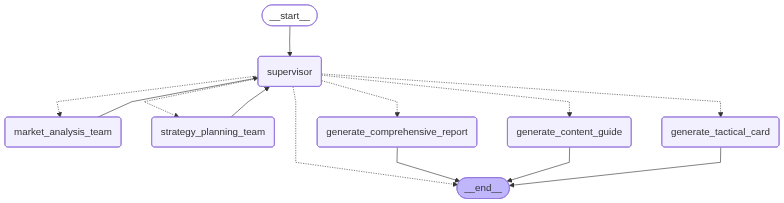

In [21]:
top_node = create_super_graph()
top_node

In [13]:

# ============================================================================
# 8. Main Execution
# ============================================================================

def run_marketing_system(
    target_store_id: str,
    target_store_name: str,
    task_type: str = "종합_전략_수립",
    user_query: Optional[str] = None,
    target_market_id: Optional[str] = None,
    period_start: Optional[str] = None,
    period_end: Optional[str] = None,
    content_channels: Optional[List[str]] = None
) -> Dict:
    """마케팅 시스템 실행"""
    start_time = time.time()
    print("=" * 80)
    print(f"🚀 Marketing MultiAgent System V2 (Integrated)")
    print(f"⏰ 시작: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("=" * 80)

    # user_query 기본값 설정
    if not user_query:
        user_query = f"Analyze {target_store_name}"

    initial_state = {
        "messages": [HumanMessage(content=f"{target_store_name} 분석 요청")],
        "user_query": user_query,  # 실제 사용자 쿼리 사용
        "target_store_id": target_store_id,
        "target_store_name": target_store_name,
        "task_type": task_type,

        # 상황 전술용
        "target_market_id": target_market_id,
        "period_start": period_start,
        "period_end": period_end,
        "situation": None,  # collect_situation_info() 결과
        "situation_context": None,

        # 콘텐츠 생성용
        "content_channels": content_channels or ['instagram', 'naver_blog', 'facebook'],

        # 공통
        "stp_output": None,
        "store_raw_data": None,
        "strategy_cards": [],
        "selected_strategy": None,
        "execution_plan": "",

        # 출력 형태별
        "final_report": "",
        "tactical_card": None,
        "content_guide": None,

        "next": ""
    }

    app = create_super_graph()
    config = {
        "configurable": {"thread_id": f"v2_integrated_{int(time.time())}"},
        "recursion_limit": 50
    }

    final_state = app.invoke(initial_state, config=config)

    elapsed = time.time() - start_time
    print("\n" + "=" * 80)
    print(f"✅ 완료 - 소요시간: {elapsed:.2f}초")
    print("=" * 80)

    return {
        "task_type": task_type,
        "stp_output": final_state.get('stp_output'),
        "strategy_cards": final_state.get('strategy_cards', []),
        "selected_strategy": final_state.get('selected_strategy'),
        "execution_plan": final_state.get('execution_plan', ''),
        "final_report": final_state.get('final_report', ''),
        "tactical_card": final_state.get('tactical_card'),
        "content_guide": final_state.get('content_guide')
    }

In [20]:

# ============================================================================
# 9. CLI
# ============================================================================

if __name__ == "__main__":
    import sys

    # 샘플 실행
    loader = PrecomputedPositioningLoader()
    loader.load_all_data()

    # 첫 번째 가맹점 사용
    if not loader.store_positioning.empty:
        sample = loader.store_positioning.iloc[0]
        store_id = sample['가맹점구분번호']
        store_name = sample['가맹점명']
    else:
        store_id = "16184E93D9"
        store_name = "성우**"

    # 🎯 작업 유형 선택
    print("\n" + "=" * 60)
    print("🎯 작업 유형을 선택하세요:")
    print("=" * 60)
    print("1. 종합_전략_수립 (STP + 4P + 전략 카드)")
    print("2. 상황_전술_제안 (날씨 + 이벤트 기반 전술)")
    print("3. 콘텐츠_생성_가이드 (SNS 무드보드 + 채널별 가이드)")
    print("=" * 60)

    choice = input("\n선택 (1-3, 기본값=1): ").strip() or "1"

    task_type_map = {
        "1": "종합_전략_수립",
        "2": "상황_전술_제안",
        "3": "콘텐츠_생성_가이드"
    }

    task_type = task_type_map.get(choice, "종합_전략_수립")
    print(f"\n✅ 선택된 작업: {task_type}\n")

    # 상황 전술용 추가 입력
    target_market_id = None
    period_start = None
    period_end = None
    content_channels = None

    if task_type == "상황_전술_제안":
        target_market_id = input("📍 상권 ID (예: M45, 기본값=성수동): ").strip() or "성수동"
        period_start = input("📅 시작일 (YYYY-MM-DD, 기본값=오늘): ").strip() or str(date.today())
        period_end = input("📅 종료일 (YYYY-MM-DD, 기본값=+7일): ").strip() or str(date.today() + timedelta(days=7))

    elif task_type == "콘텐츠_생성_가이드":
        channels_input = input("📱 채널 (쉼표 구분, 기본값=Instagram,Naver Blog): ").strip()
        if channels_input:
            content_channels = [ch.strip() for ch in channels_input.split(",")]
        else:
            content_channels = ["Instagram", "Naver Blog"]

    # 실행
    result = run_marketing_system(
        target_store_id=store_id,
        target_store_name=store_name,
        task_type=task_type,
        target_market_id=target_market_id,
        period_start=period_start,
        period_end=period_end,
        content_channels=content_channels
    )

    print(f"\n📊 결과:")
    print(f"- 작업 유형: {result['task_type']}")

    if task_type == "종합_전략_수립":
        print(f"- 전략 카드 수: {len(result['strategy_cards'])}")
        if result['selected_strategy']:
            print(f"- 선택된 전략: {result['selected_strategy'].title}")
            print(f"- 우선순위: {result['selected_strategy'].priority}")
        print(f"\n{result['final_report']}")

    elif task_type == "상황_전술_제안":
        print(f"\n{result.get('tactical_card', '전술 카드 없음')}")

    elif task_type == "콘텐츠_생성_가이드":
        content_guide = result.get('content_guide', {})
        if content_guide:
            print(f"\n🎨 무드보드: {', '.join(content_guide.get('mood_board', []))}")
            print(f"🎭 톤앤매너: {content_guide.get('brand_tone', 'N/A')}")
            print(f"📺 채널 수: {len(content_guide.get('channels', []))}")
        print(f"\n{result.get('final_report', '보고서 없음')}")


✅ STP 데이터 로드 완료

🎯 작업 유형을 선택하세요:
1. 종합_전략_수립 (STP + 4P + 전략 카드)
2. 상황_전술_제안 (날씨 + 이벤트 기반 전술)
3. 콘텐츠_생성_가이드 (SNS 무드보드 + 채널별 가이드)

✅ 선택된 작업: 종합_전략_수립

🚀 Marketing MultiAgent System V2 (Integrated)
⏰ 시작: 2025-10-26 15:55:26

[Supervisor] 작업 유형: 종합_전략_수립
[Supervisor] → Market Analysis Team

[Segmentation] 시장 군집 분석 중...
✅ STP 데이터 로드 완료
[Targeting] 타겟 군집 선정 중...
✅ STP 데이터 로드 완료
[Positioning] 차별화 포지션 탐색 중...
✅ STP 데이터 로드 완료
[Market Team] 완료

[Supervisor] 작업 유형: 종합_전략_수립
[Supervisor] → Strategy Planning Team (종합_전략_수립)

[STP Validation] STP 분석 결과 검증 중...
   ℹ️  4P Mapper 미설치: 기본 데이터로 진행
[4P Strategy] 데이터 기반 3개 전략 카드 생성 중...


DefaultCredentialsError: Your default credentials were not found. To set up Application Default Credentials, see https://cloud.google.com/docs/authentication/external/set-up-adc for more information.

In [ ]:

with tab1:
    st.markdown("## 📊 STP 분석")
    stp = result.get('stp_output')
    
    if stp:
        # 포지셔닝 맵
        fig = create_positioning_map(stp)
        if fig:
            st.plotly_chart(fig, use_container_width=True)
        
        # 클러스터 정보
        st.markdown("### 군집 정보")
        for cluster in stp.cluster_profiles:
            st.info(f"**{cluster.cluster_name}**: {cluster.characteristics}")
    else: